In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide
import os
from utils import *
import pandas as pd
import cartopy.feature as cfeature
import xesmf as xe
from scipy.ndimage import gaussian_filter

# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy


#datadir = './'
datadir = '/home/cercache/users/cgonzale/data/test/'
graphdir = '/home3/homedir7/perso/cgonzale/IWAVE/figures/'
bathy = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
datadir_tides = '/home2/pharos/othr/aponte/tides/HRET/'
# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#compute gradients of SST for a day with more than one image 
#Region = 'Mozamb4'
#day = '20160504'

Region = 'Mozamb2'
day = '20140605'
zoomer = False
#day = '20140606'
#day = '20140604'
year_folder = day[0:4]
day_folder = date_to_nth_day(day)
print(year_folder,day_folder)

2014 156


In [3]:
#Read csv with all available SST images for the region
path_available_files = datadir+ 'Available_images_LOG' + os.sep
name_file = Region + '_available_SST_images.csv'

#may check if the file already exist otherwise call available_SST_images.py to create it

SST_files = pd.read_csv(path_available_files+name_file, sep='\t')

In [4]:
#print(SST_files)

     Unnamed: 0      date                                               path
0             0  20141102  /home/cercache/users/cgonzale/data/test/Mozamb...
1             0  20141102  /home/cercache/users/cgonzale/data/test/Mozamb...
2             0  20141121  /home/cercache/users/cgonzale/data/test/Mozamb...
3             0  20141121  /home/cercache/users/cgonzale/data/test/Mozamb...
4             0  20141205  /home/cercache/users/cgonzale/data/test/Mozamb...
5             0  20141205  /home/cercache/users/cgonzale/data/test/Mozamb...
6             0  20141205  /home/cercache/users/cgonzale/data/test/Mozamb...
7             0  20140305  /home/cercache/users/cgonzale/data/test/Mozamb...
8             0  20140305  /home/cercache/users/cgonzale/data/test/Mozamb...
9             0  20140530  /home/cercache/users/cgonzale/data/test/Mozamb...
10            0  20140530  /home/cercache/users/cgonzale/data/test/Mozamb...
11            0  20140531  /home/cercache/users/cgonzale/data/test/Mozamb...

In [4]:
dfile = SST_files.loc[SST_files['date'].isin([day])]
print(dfile)

    Unnamed: 0      date                                               path
27           0  20140605  /home/cercache/users/cgonzale/data/test/Mozamb...
28           0  20140605  /home/cercache/users/cgonzale/data/test/Mozamb...
29           0  20140605  /home/cercache/users/cgonzale/data/test/Mozamb...
30           0  20140605  /home/cercache/users/cgonzale/data/test/Mozamb...
31           0  20140605  /home/cercache/users/cgonzale/data/test/Mozamb...


In [5]:
list_file = dfile['path'].values.tolist()

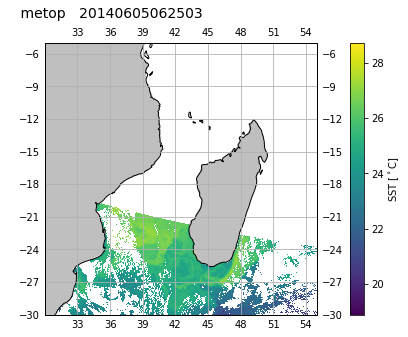

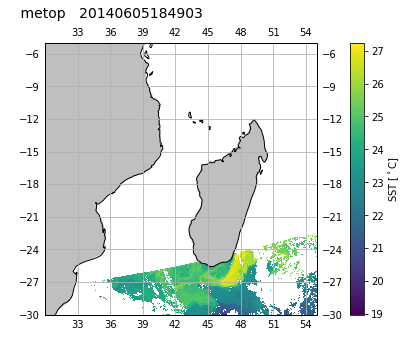

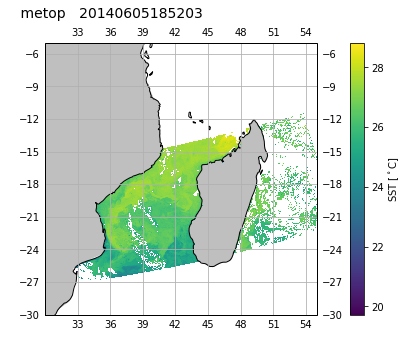

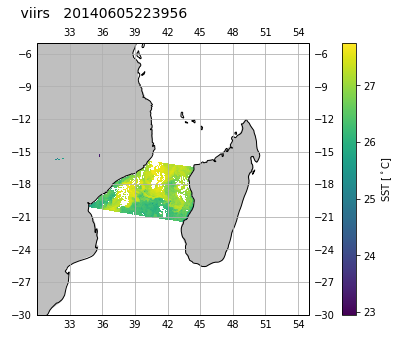

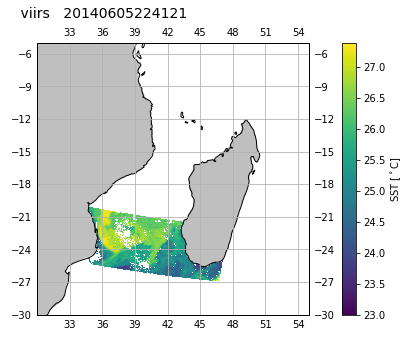

In [6]:
#First exploration of the available images
#read all files and plot SST
for f in list_file:
    # load NetCDF 
    name_file = f.rsplit(os.sep,1)[1].rsplit('.',2)[0]
    date_time = name_file[0:14]
    sensor = f.rsplit(os.sep,4)[1]
    h = xr.open_dataset(f) 
    h.set_coords(['lon','lat'], inplace=True)
    toplt = h['sea_surface_temperature'].isel(time=0)-273.15#convert to degrees
    lonmin =toplt.lon.min()
    lonmax = toplt.lon.max()
    latmin = toplt.lat.min()
    latmax = toplt.lat.max()
    img_extent = (lonmin, lonmax, latmin, latmax)

    fig = plt.figure(figsize=(12, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, ax=ax)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    ax.gridlines(draw_labels = True)
    cbar.set_label('SST [$^\circ$C]')
    #may convert date_time in to date format YYYYMMDD hh:mm:ss)
    plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
    

In [7]:
#read and merge all files
ds = xr.merge([xr.open_dataset(f) for f in list_file])

In [8]:
print(ds)

<xarray.Dataset>
Dimensions:                      (ni: 1251, nj: 1251, time: 5)
Coordinates:
  * time                         (time) datetime64[ns] 2014-06-05T06:25:03 ...
    lat                          (nj) float32 -30.01 -29.99 -29.97 -29.95 ...
    lon                          (ni) float32 30.01 30.03 30.05 30.07 30.09 ...
Dimensions without coordinates: ni, nj
Data variables:
    quality_level                (time, nj, ni) float64 nan nan nan nan nan ...
    sea_surface_temperature      (time, nj, ni) float64 nan nan nan nan nan ...
    sst_dtime                    (time, nj, ni) float64 -9.223e+18 ...
    satellite_zenith_angle       (time, nj, ni) float64 nan nan nan nan nan ...
    sses_bias                    (time, nj, ni) float64 nan nan nan nan nan ...
    sses_standard_deviation      (time, nj, ni) float64 nan nan nan nan nan ...
    brightness_temperature_4um   (time, nj, ni) float64 nan nan nan nan nan ...
    brightness_temperature_11um  (time, nj, ni) float64 nan nan 

In [9]:
ds.set_coords(['lon','lat'], inplace=True)
print(ds)

<xarray.Dataset>
Dimensions:                      (ni: 1251, nj: 1251, time: 5)
Coordinates:
  * time                         (time) datetime64[ns] 2014-06-05T06:25:03 ...
    lat                          (nj) float32 -30.01 -29.99 -29.97 -29.95 ...
    lon                          (ni) float32 30.01 30.03 30.05 30.07 30.09 ...
Dimensions without coordinates: ni, nj
Data variables:
    quality_level                (time, nj, ni) float64 nan nan nan nan nan ...
    sea_surface_temperature      (time, nj, ni) float64 nan nan nan nan nan ...
    sst_dtime                    (time, nj, ni) float64 -9.223e+18 ...
    satellite_zenith_angle       (time, nj, ni) float64 nan nan nan nan nan ...
    sses_bias                    (time, nj, ni) float64 nan nan nan nan nan ...
    sses_standard_deviation      (time, nj, ni) float64 nan nan nan nan nan ...
    brightness_temperature_4um   (time, nj, ni) float64 nan nan nan nan nan ...
    brightness_temperature_11um  (time, nj, ni) float64 nan nan 

In [10]:
Nt = ds.dims['time']
it = np.arange(Nt)
it = np.linspace(0,Nt-1,num = Nt)
print(it)

[0. 1. 2. 3. 4.]


In [11]:
t = ds['sea_surface_temperature']-273.15
print(t)

<xarray.DataArray 'sea_surface_temperature' (time: 5, nj: 1251, ni: 1251)>
array([[[  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]],

       [[  nan,   nan, ..., 20.72, 20.89],
        [  nan,   nan, ..., 20.78, 20.82],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]],

       ...,

       [[  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]],

       [[  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2014-06-05T06:25:03 2014-06-05T18:49:03 ...
    lat      (nj) float32 -30.01 -29.99 -29.97 -29.95 -29.93 -29.91 -29.

In [14]:
#t = ds['sea_surface_temperature'].isel(time = [1])
#print(t)

In [15]:
#select a smaller region
#mozamb4
if (Region == 'Mozamb4'):
    latmin_z = -18
    latmax_z = -12
    lonmin_z = 52
    lonmax_z = 55
#mozamb2
if (Region == 'Mozamb2') and zoomer:
    latmin_z = -27
    latmax_z = -26
    lonmin_z = 45
    lonmax_z = 46
else:
    latmin_z = -30
    latmax_z = -24
    lonmin_z = 42
    lonmax_z = 48

toplt_zoom = t.where(t['lon']>=lonmin_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lon']<=lonmax_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lat']<=latmax_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lat']>=latmin_z, drop=True)


In [16]:
mask_toplt_zoom = np.isnan(toplt_zoom.values)
print(mask_toplt_zoom.shape)

dum_mask = np.zeros(mask_toplt_zoom.shape)+1

dum_mask[mask_toplt_zoom]=0


(5, 300, 300)


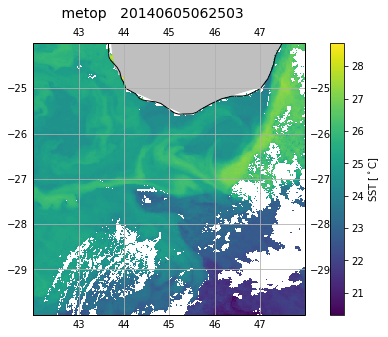

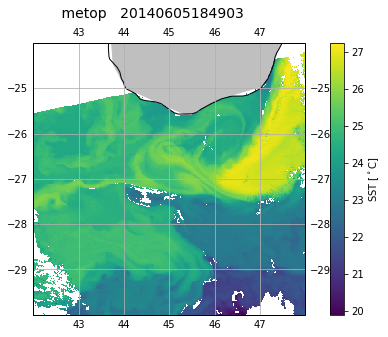

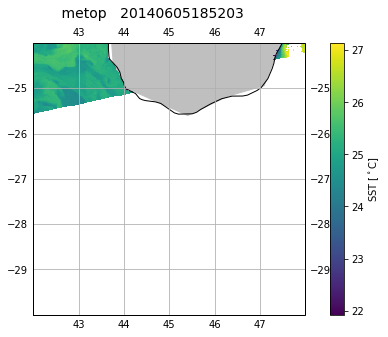

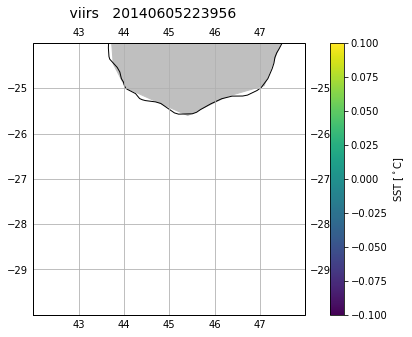

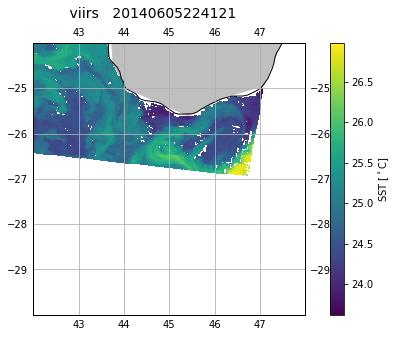

In [45]:
img_extent = (lonmin_z, lonmax_z, latmin_z, latmax_z)


for i in range(Nt):
    fig = plt.figure(figsize=(9, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.imshow(toplt_zoom[i,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, ax=ax)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    ax.gridlines(draw_labels = True)
    cbar.set_label('SST [$^\circ$C]')
    name_fig = list_file[i].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    name_file = list_file[i].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    date_time = name_file[0:14]
    sensor = list_file[i].rsplit(os.sep,4)[1]
    plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
    plt.savefig(graphdir+os.sep+Region+os.sep+name_fig+'.png')
    plt.show()

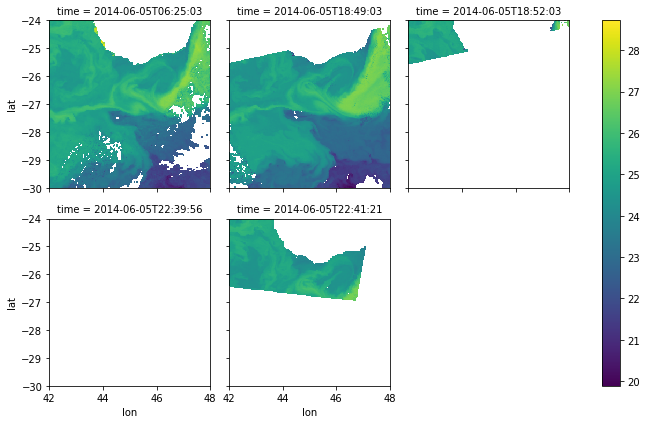

In [18]:
g_simple = toplt_zoom.plot(x='lon', y='lat', col='time', col_wrap=3)

In [19]:
dlon = toplt_zoom['lon'].diff('ni').mean()
dlat = toplt_zoom['lat'].diff('nj').mean()

R_earth = 6378100 #earth radius m
deg2rad = np.pi/180
R_conv = R_earth*deg2rad
print(R_conv)

dy = (dlat*R_conv)
dx = dlon*R_conv*np.cos(deg2rad*toplt_zoom['lat'].mean())

dx = dx.values
dy = dy.values

print(dlon, dlat)
print(dx,dy)

111318.84502145034
<xarray.DataArray 'lon' ()>
array(0.02) <xarray.DataArray 'lat' ()>
array(0.02)
1983.7174750279403 2226.3766433180986


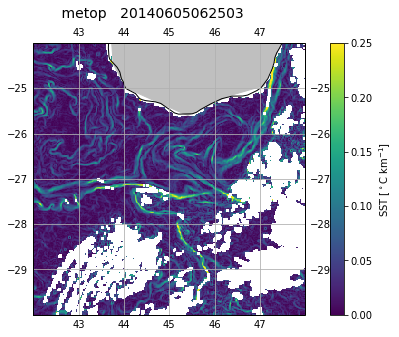

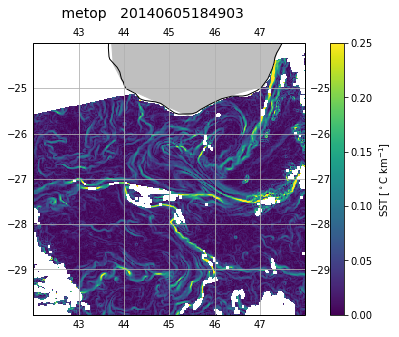

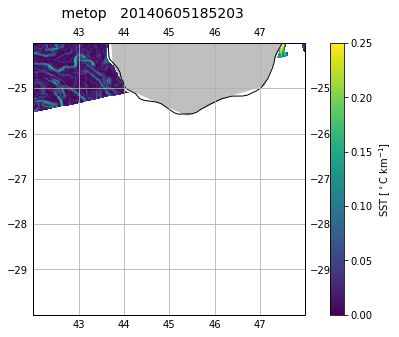

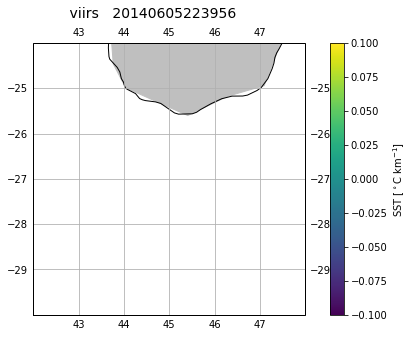

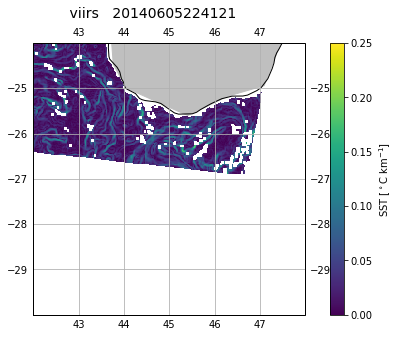

In [46]:
for i in range(Nt):

    sobel_y, sobel_x = sobel_gradient(toplt_zoom[i,:,:], dx, dy)
    sobel_grad =  np.sqrt(sobel_x**2+sobel_y**2)
    fig = plt.figure(figsize=(9, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.imshow(sobel_grad*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=0.25)
    cbar = fig.colorbar(cs, ax=ax)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    ax.gridlines(draw_labels = True)
    cbar.set_label('SST [$^\circ$C km$^{-1}$]')
    name_file = list_file[i].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    date_time = name_file[0:14]
    sensor = list_file[i].rsplit(os.sep,4)[1]
    plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
    name_fig = list_file[i].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    plt.savefig(graphdir+os.sep+Region+os.sep+'GRADIENT_'+name_fig+'.png')



---

In [21]:
#read tides
hret, constituents, omega = get_hret_ssh(constituents=['M2'], lonb=(lonmin_z, lonmax_z), latb=(latmin_z, latmax_z), hret=datadir_tides+'/Carrere_HRET_testing.nc',bathy=bathy)
print(hret)

M2 omega=1.405189e-04 rad/s, 1.932 cpd
/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc
<xarray.Dataset>
Dimensions:    (latitude: 120, longitude: 121)
Coordinates:
  * longitude  (longitude) float64 42.0 42.05 42.1 42.15 42.2 42.25 42.3 ...
  * latitude   (latitude) float64 -30.0 -29.95 -29.9 -29.85 -29.8 -29.75 ...
Data variables:
    M2re       (latitude, longitude) float64 dask.array<shape=(120, 121), chunksize=(120, 121)>
    M2im       (latitude, longitude) float64 dask.array<shape=(120, 121), chunksize=(120, 121)>
    mask       (latitude, longitude) float64 dask.array<shape=(120, 121), chunksize=(120, 121)>
    h          (latitude, longitude) float64 4.165e+03 4.129e+03 4.146e+03 ...
Attributes:
    history:                  merged txa/j1a/j2a, txb/j1b, g1a, and e2a/n1b/s...
    resolution:               The spatial basis function coefficients are def...
    creator:                  Ed Zaron, ezaron@pdx.edu
    post-processing scripts:  baburu:NASA-Tides/Julia/; this file was 

In [22]:
U, V, constituents, omega = get_hret_uv(constituents=['M2','K1'], lonb=(lonmin_z, lonmax_z), latb=(latmin_z, latmax_z), hret=datadir_tides+'/Carrere_HRET_testing.nc', bathy=bathy)

K1 omega=7.292116e-05 rad/s, 1.003 cpd
M2 omega=1.405189e-04 rad/s, 1.932 cpd
/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc
7.292116514526208e-05


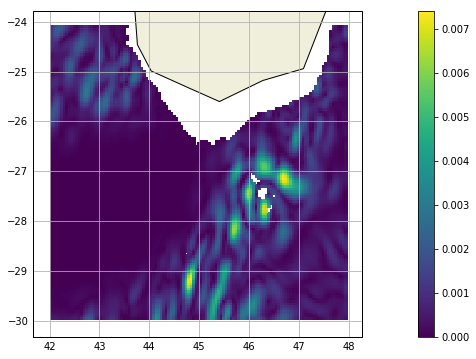

In [47]:
cst = 'M2'
hc=1000.

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111, projection=crs)
#
toplt = np.abs(U['M2']**2+V['M2']**2)
toplt = toplt.where(hret['h']>hc)
toplt.plot()
#ax.set_title(cst+' real(U)')
gl = ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cfeature.LAND)
plt.show()

---

Regridding tides data

In [24]:
latitude_tides = U['latitude']
longitude_tides = U['longitude']

print(latitude_tides.shape)
print(longitude_tides.shape)

(119,)
(120,)


In [25]:
lat_sst = toplt_zoom.lat
lon_sst = toplt_zoom.lon

In [26]:
#Regriding tides data
# output grid has a larger coverage and finer resolution
grid_in = {'lon': longitude_tides,
            'lat': latitude_tides
           }

grid_out = {'lon': lon_sst,
            'lat': lat_sst
           }

In [27]:
#perform regridding
regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
regridder.clean_weight_file()
regridder

Create weight file: bilinear_119x120_300x300.nc
Remove file bilinear_119x120_300x300.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_119x120_300x300.nc 
Reuse pre-computed weights? False 
Input grid shape:           (119, 120) 
Output grid shape:          (300, 300) 
Output grid dimension name: ('nj', 'ni') 
Periodic in longitude?      False

In [28]:
data = np.real(U['M2'])
print(data.shape)
U_out = regridder(U['M2'])  # regrid a basic numpy array
U_out.shape
V_out = regridder(V['M2']) 

(119, 120)


In [29]:
print(V_out)

<xarray.DataArray 'M2' (nj: 300, ni: 300)>
array([[nan+nanj, nan+nanj, nan+nanj, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [nan+nanj, nan+nanj, nan+nanj, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [nan+nanj, nan+nanj, nan+nanj, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       ...,
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j]])
Coordinates:
    lon      (ni) float32 42.01 42.03 42.05 42.07 42.09 42.11 42.13 42.15 ...
    lat      (nj) float32 -29.99 -29.97 -29.95 -29.93 -29.91 -29.89 -29.87 ...
Dimensions without coordinates: nj, ni
Attributes:
    regrid_method:  bilinear


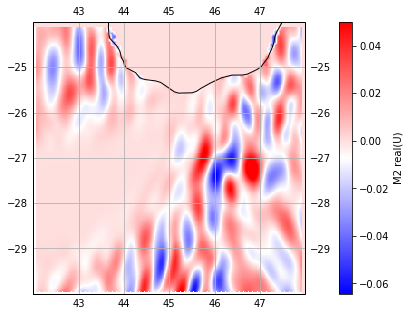

In [52]:
toplt = np.real(U_out)

fig = plt.figure(figsize=(12, 5))
ax.set_title(cst+' real(V)')
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmax = 0.05, cmap = 'bwr')
cbar = fig.colorbar(cs, ax=ax)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label(cst+' real(U)')
plt.show()

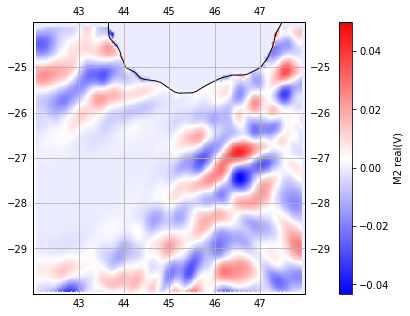

In [51]:

toplt = np.real(V_out)

fig = plt.figure(figsize=(12, 5))
ax.set_title(cst+' real(V)')
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmax = 0.05, cmap = 'bwr')
cbar = fig.colorbar(cs, ax=ax)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label(cst+' real(V)')
plt.show()

In [32]:
omega['M2']*cpd

0.00014051890276074673

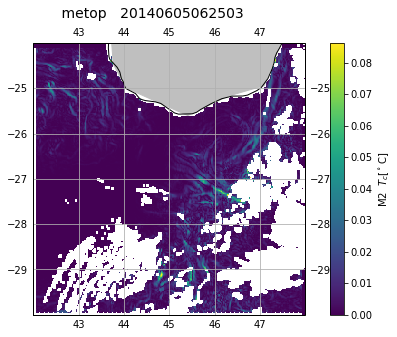

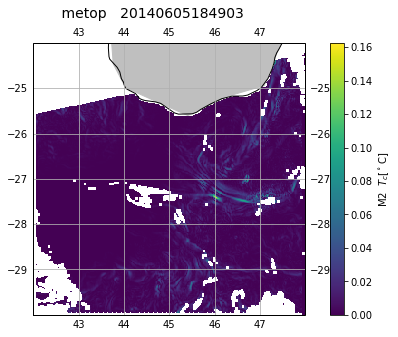

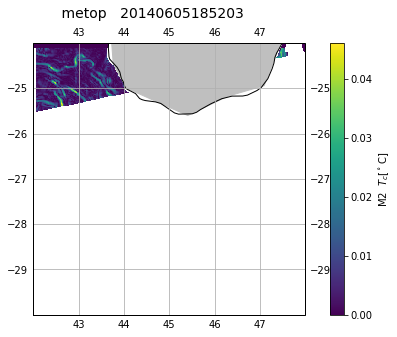

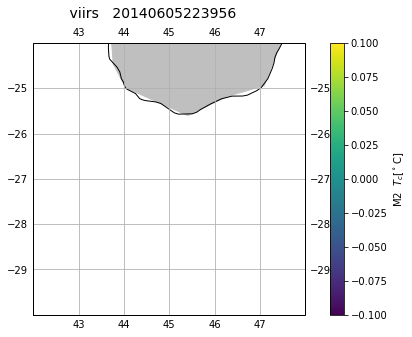

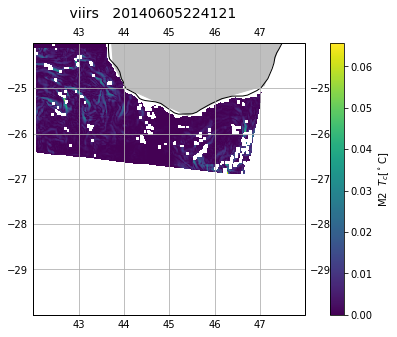

In [55]:
for i in range(Nt):

    sobel_y, sobel_x = sobel_gradient(toplt_zoom[i,:,:], dx, dy)
    sobel_grad =  np.sqrt(sobel_x**2+sobel_y**2)

    Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
    toplt = np.abs(Tc)

    fig = plt.figure(figsize=(9, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, ax=ax)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    ax.gridlines(draw_labels = True)
    cbar.set_label(cst+  r'  $T_c[^\circ$C]')
    name_file = list_file[i].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    date_time = name_file[0:14]
    sensor = list_file[i].rsplit(os.sep,4)[1]
    plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
    name_fig = list_file[i].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    plt.savefig(graphdir+os.sep+Region+os.sep+'Tc_'+name_fig+'.png')
    plt.show()